In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import string
import random
import unicodedata
import re
import keras
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('gutenberg')

from keras.models import Sequential
from keras.layers.core import Dense, Reshape, Lambda
from keras.layers import dot
from keras.layers.embeddings import Embedding
from nltk.corpus import gutenberg

class Tools:
  @staticmethod
  def preprocessor(document):
    #f = open(document, "r")
    doc = Tools.prepare_doc(document)
    wids = []
    for line in doc:
      t = tf.keras.preprocessing.text.text_to_word_sequence(line)
      if (len(t) > 2):
        wids.append(t)
    return doc, wids
  
  @staticmethod
  def prepare_doc(file):
    wpt = nltk.WordPunctTokenizer()
    stop_words = nltk.corpus.stopwords.words('english')

    #lines = file.readlines()
    norm = [' '.join(line) for line in file]
    doc = []
    #read = False
    for line in norm:
      #removing whitespaces from a line
      line = line.strip()
      #if ("START OF THIS PROJECT" in line):
        #read = True
      #if ("END OF THIS PROJECT" in line):
        #read = False
      excludeList = ['chapter', 'contents', 'preface']
      if (line):
        #excluding lines containing unwanted words
        if (not any(str in line.lower() for str in excludeList)):
          #change to lower case
          line = line.lower()
          #normalizing all characters to ascii format
          line = unicodedata.normalize('NFKD', line).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          #removing any numeric digits
          line = re.sub(r'[^\x00-\x7f]', r'', line)
          #remove special characters
          line = re.sub(r'[^a-zA-Z\s]', '', line, re.I|re.A)
          #removing punctuations
          ignore_list = string.punctuation + '0123456789'
          line = "".join(c for c in line if c not in ignore_list)
          # tokenize document
          tokens = wpt.tokenize(line)
          # filter stopwords out of document
          filtered_tokens = [token for token in tokens if token not in stop_words]
          # re-create document from filtered tokens
          line = ' '.join(filtered_tokens)
          #appending lines to the doc in lower case
          doc.append(line)
    return doc

  @staticmethod
  def generate_vocab(doc):
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(doc)
    word2id = tokenizer.word_index
    return word2id

  @staticmethod
  def convert_id_to_word(word2id):
    return {i:k for k, i in word2id.items()}
  
  @staticmethod
  def get_score(x, y, sentence):
    start = sentence.index(x)
    end = sentence.index(y)
    #score = 1/(2**(abs(start-end)-1))
    denom = abs(start-end)
    score = 0.0
    if (denom > 0):
      score = 1/(denom)
    return float(score)

  @staticmethod
  def generate_negative_samples(vocab_size, x, y, x_data, y_data, multiplier=1):
    total_samples = len(y) * multiplier
    count = 0
    while (count < total_samples):
      sample = np.random.randint(1,vocab_size-1,size=1)[0]
      if (sample not in y):
        count += 1
        x_data.append([x,sample])
        y_data.append(0.0)
    return x_data, y_data
  
  @staticmethod
  def get_skip_grams(wids, vocab_size, win_size, baseline=True):
    if (baseline):
      return [tf.keras.preprocessing.sequence.skipgrams(wid, vocabulary_size=vocab_size, window_size=win_size) for wid in wids]
    else:
      skip_grams = []
      for wid in wids:
        tuple_data = []
        labels = []
        sentence = wid
        window_size = win_size
        window_sequences = [sentence[max((ix-window_size),0):(ix+window_size+1)] for ix, x in enumerate(sentence)]
        label_indices = [ix if ix<window_size else window_size for ix,x in enumerate(window_sequences)]
        batch_and_labels = [(x[y], x[:y] + x[(y+1):]) for x,y in zip(window_sequences, label_indices)]
        #data = [(x, y_) for x,y in batch_and_labels for y_ in y]

        for x,y in batch_and_labels:
          for y_ in y:
            score = Tools.get_score(x,y_,sentence)
            tuple_data.append([x,y_])
            labels.append(score)
          tuple_data, labels = Tools.generate_negative_samples(vocab_size, x, y, tuple_data, labels, multiplier=1)
        skipgram = list(zip(tuple_data, labels))
        random.shuffle(skipgram)
        tuple_data[:], labels[:] = zip(*skipgram)
        skip_grams.append(tuple([tuple_data, labels]))
      return skip_grams


  @staticmethod
  def get_skip_gram_model(vocab_size, embed_size):
    word_model_input = keras.Input(shape=(1,))
    word_model_embed_layer = Embedding(vocab_size, embed_size,
                            embeddings_initializer="glorot_uniform",
                            input_length=1)(word_model_input)
    word_model_reshape_layer = Reshape((embed_size,))(word_model_embed_layer)
    word_model = keras.Model(inputs=word_model_input, outputs=word_model_reshape_layer)

    context_model_input = keras.Input(shape=(1,))
    context_model_embed_layer = Embedding(vocab_size, embed_size,
                      embeddings_initializer="glorot_uniform",
                      input_length=1)(context_model_input)
    context_model_reshape_layer = Reshape((embed_size,))(context_model_embed_layer)
    context_model = keras.Model(inputs=context_model_input, outputs=context_model_reshape_layer)

    dot_layer = dot([word_model.output, context_model.output], axes=1, normalize=False)
    dense_layer_output = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(dot_layer)
    model = keras.Model(inputs=[word_model.input, context_model.input], outputs=dense_layer_output)
    model.compile(loss='mean_squared_error', optimizer="rmsprop")
    return model

  # function to convert numbers to one hot vectors
  @staticmethod
  def to_one_hot(data_point_index, vocab_size):
      temp = np.zeros(vocab_size)
      temp[data_point_index] = 1
      return temp

  @staticmethod
  def train(model, skip_grams):
    for epoch in range(6):
      loss = 0
      for i, elem in enumerate(skip_grams):
          pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
          pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
          labels = np.array(elem[1], dtype='int32')
          X = [pair_first_elem, pair_second_elem]
          Y = labels
          if i % 10000 == 0:
              print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
          loss += model.train_on_batch(X,Y)  

      print('Epoch:', epoch, 'Loss:', loss)


Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


In [0]:
#Get preprocessed document and corresponding word sequences'austen-emma.txt',
doc1 = gutenberg.sents('austen-persuasion.txt')
doc2 = gutenberg.sents('austen-sense.txt')
doc3 = gutenberg.sents('bible-kjv.txt')
doc4 = gutenberg.sents('blake-poems.txt')
doc5 = gutenberg.sents('shakespeare-macbeth.txt')
args = (doc1,doc2,doc3,doc4,doc5)
document = np.concatenate(args)

doc, wids = Tools.preprocessor(document)

#Generate vocabulary from the document
word2id = Tools.generate_vocab(doc)
vocab_size = len(word2id)+1
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

#print (doc)
print (wids[0])

#Generate id2word mappings
id2word = Tools.convert_id_to_word(word2id)

#Express word sequences in ID form
wids = [[word2id[w] for w in wid] for wid in wids]
#wids = [[word2id[w] for w in tf.keras.preprocessing.text.text_to_word_sequence(doc)] for doc in norm_bible]

#Generate skipgrams
window_size = 10
skipgrams = Tools.get_skip_grams(wids, vocab_size, window_size, baseline=False)

#Visualize skipgrams
pairs, labels = skipgrams[0][0], skipgrams[0][1]

for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:f}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

#Get skipgram model
embed_size = 100
model = Tools.get_skip_gram_model(vocab_size, embed_size)

#Model summary
print(model.summary())
# visualize model structure
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 #rankdir='TB').create(prog='dot', format='svg'))

#Train the model
Tools.train(model, skipgrams)

Vocabulary Size: 19178
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('said', 6), ('god', 7), ('ye', 8), ('thee', 9), ('man', 10)]
['persuasion', 'jane', 'austen']
(persuasion (2745), weave (7946)) -> 0.000000
(austen (9580), jane (9579)) -> 1.000000
(jane (9579), austen (9580)) -> 1.000000
(austen (9580), proclaiming (7503)) -> 0.000000
(jane (9579), persuasion (2745)) -> 1.000000
(jane (9579), guilty (2070)) -> 0.000000
(austen (9580), persuasion (2745)) -> 0.500000
(jane (9579), kadeshbarnea (4628)) -> 0.000000
(persuasion (2745), temptations (5299)) -> 0.000000
(persuasion (2745), austen (9580)) -> 0.500000
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
____________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Processed 30000 (skip_first, skip_second, relevance) pairs
Epoch: 0 Loss: 3908.0998442005366
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Processed 30000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 3769.989187014289
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Processed 30000 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 3752.127776256297
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Processed 30000 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 3742.5135461

In [0]:
import random

def get_score(x, y, sentence):
  start = sentence.index(x)
  end = sentence.index(y)
  #score = 1/(2**(abs(start-end)-1))
  score = 1/(abs(start-end))
  return float(score)

def generate_negative_samples(vocab_size, x, y, x_data, y_data, multiplier=1):
  total_samples = len(y) * multiplier
  count = 0
  while (count < total_samples):
    sample = np.random.randint(1,vocab_size-1,size=1)[0]
    if (sample not in y):
      count += 1
      x_data.append([x,sample])
      y_data.append(0.0)
  return x_data, y_data

tuple_data = []
labels = []
rand_sentence = wids[0]
print (rand_sentence)
window_size = 10
window_sequences = [rand_sentence[max((ix-window_size),0):(ix+window_size+1)] for ix, x in enumerate(rand_sentence)]
print (window_sequences)
label_indices = [ix if ix<window_size else window_size for ix,x in enumerate(window_sequences)]
batch_and_labels = [(x[y], x[:y] + x[(y+1):]) for x,y in zip(window_sequences, label_indices)]
data = [(x, y_) for x,y in batch_and_labels for y_ in y]
print (data)

for x,y in batch_and_labels:
  for y_ in y:
    score = get_score(x,y_,rand_sentence)
    tuple_data.append([x,y_])
    labels.append(score)
  tuple_data, labels = generate_negative_samples(vocab_size, x, y, tuple_data, labels, multiplier=1)
print (tuple_data)
print (labels)
skip_grams = []
skipgram = list(zip(tuple_data, labels))
random.shuffle(skipgram)
tuple_data[:], labels[:] = zip(*skipgram)
skip_grams.append(tuple([tuple_data, labels]))
print (tuple_data)
print (labels)
m = skip_grams
print (m[0])

[2745, 9579, 9580]
[[2745, 9579, 9580], [2745, 9579, 9580], [2745, 9579, 9580]]
[(2745, 9579), (2745, 9580), (9579, 2745), (9579, 9580), (9580, 2745), (9580, 9579)]
[[2745, 9579], [2745, 9580], [2745, 4888], [2745, 4684], [9579, 2745], [9579, 9580], [9579, 5868], [9579, 3267], [9580, 2745], [9580, 9579], [9580, 3357], [9580, 333]]
[1.0, 0.5, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.5, 1.0, 0.0, 0.0]
[[9579, 3267], [2745, 9580], [2745, 9579], [9579, 5868], [9580, 333], [9580, 2745], [9580, 9579], [9579, 9580], [9580, 3357], [2745, 4888], [2745, 4684], [9579, 2745]]
[0.0, 0.5, 1.0, 0.0, 0.0, 0.5, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0]
([[9579, 3267], [2745, 9580], [2745, 9579], [9579, 5868], [9580, 333], [9580, 2745], [9580, 9579], [9579, 9580], [9580, 3357], [2745, 4888], [2745, 4684], [9579, 2745]], [0.0, 0.5, 1.0, 0.0, 0.0, 0.5, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0])


In [0]:
#dotted_layer = model.layers[1]
#print (len(model.layers))
#word_model = dotted_layer.layers[0]
word_model_embed_layer = model.layers[2]
weights = word_model_embed_layer.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

(19177, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
shall,-1.454634,0.976576,-0.323243,1.474354,-1.296347,1.004094,-0.281040,-0.856611,1.688389,-1.930333,-0.750391,1.990577,1.506496,-0.820124,-1.380119,0.690481,-0.728226,1.795753,-0.943066,1.189331,0.778264,-1.925284,-1.059598,-1.900478,0.118191,-0.529442,-1.351030,-1.127245,0.721218,0.101422,-1.898571,-0.994868,0.877956,-0.259409,-0.960157,1.171509,1.084331,0.485500,1.050763,0.330404,...,-1.465930,-1.353988,-0.854958,-0.394421,1.617234,-1.111200,-1.628738,0.833151,-2.444904,-1.112670,-0.753993,-1.636834,0.575714,-2.176028,1.246622,-1.534943,1.043339,0.798295,0.408191,-1.247705,1.769812,-0.020207,-1.026498,0.882441,1.267772,-1.370579,-1.736550,-2.778882,1.274175,-1.779396,0.858288,0.899009,1.344799,1.257526,1.616890,-0.411768,-1.886238,-0.760654,1.885087,1.055399
unto,2.287660,-1.991975,-1.136879,1.101195,1.164470,-0.479945,2.359250,0.924077,-0.917022,-1.447385,-1.199228,0.979525,-1.122820,1.228818,0.575405,-1.250430,-1.595516,2.078690,-1.638583,0.853028,0.932317,-1.356756,-1.528407,1.060518,0.752917,-1.384151,0.456413,-1.502952,0.868340,1.837675,-1.035267,0.978073,-1.522367,-1.217541,2.191249,1.216975,1.662663,0.973865,-0.699277,1.773912,...,0.202681,-1.535542,-1.393459,-0.679564,-1.680064,-0.316383,1.017781,-1.924145,1.196439,1.399908,0.880610,-1.128807,-0.219211,0.998369,0.899266,0.900645,-1.223536,-1.630176,1.611147,0.816297,0.930295,1.414046,-0.939505,1.535202,-1.541851,1.840580,1.504405,-0.441719,1.502831,-0.591864,0.801468,1.094242,1.347294,-2.184315,1.992676,1.599189,1.575858,-1.292703,0.217862,1.633470
lord,-1.581252,-3.121548,1.086024,-2.018766,1.550684,0.383539,1.992653,-0.704401,-0.039884,2.191228,2.993959,-0.683768,0.228352,0.367610,0.825141,-1.652452,1.906794,2.153583,-0.605111,-1.464532,0.301286,-2.039753,-1.525566,-1.127557,-1.663398,1.772491,-1.030901,-0.389598,-1.290193,1.026871,1.365111,-1.922947,-1.705172,-1.278460,-0.582056,2.364464,-2.434019,1.048992,1.227430,-1.797880,...,2.478277,-1.628869,-1.709758,0.966585,1.723975,-0.016284,0.620633,-0.810799,1.567897,0.442918,-1.363189,1.175919,1.678517,0.384053,1.452268,-1.496118,-0.745009,-1.224638,-2.358327,0.588619,0.361848,-1.927583,1.917729,1.543248,-2.073892,2.959708,2.221956,-1.771807,1.558273,0.576349,-1.100823,-0.574704,1.338499,1.538380,-1.046741,0.225160,1.993890,-1.310557,-0.868611,-0.467306
thou,1.696714,2.273160,0.770179,-0.625706,1.284027,0.920337,-1.830392,-1.767295,0.565551,1.770367,1.285004,-0.795427,1.776378,-1.774854,0.766967,-3.061454,-1.637290,-1.545660,1.015718,1.860911,-0.669375,2.591564,1.764064,-2.191486,2.361608,1.259538,-1.482274,-1.165727,-0.941648,-2.270108,-1.657542,1.386636,1.874764,0.454724,-1.937641,0.953281,2.639003,-0.228554,0.108681,1.853253,...,1.406785,-1.774692,-0.128060,0.638651,-0.414971,-1.304748,-1.671232,0.634885,-1.454911,-1.284478,1.053384,-1.984055,-1.472017,-0.912976,-1.125003,0.804903,1.547619,-0.824786,-1.340613,0.608669,-1.390277,1.093261,0.882607,-1.189485,1.524514,1.494735,1.492231,-3.925021,2.214953,1.200667,1.241978,-2.140675,-0.695512,-0.188232,-0.877009,1.230353,-1.584524,-1.082469,1.771627,-0.287695
thy,-1.769055,1.005794,0.881261,-0.951039,0.347551,-0.150544,-1.401390,-0.990847,-1.480039,2.059376,1.536125,1.526497,0.603975,-0.947194,1.195618,0.677644,1.104475,1.566262,0.069395,-1.631238,-1.778474,-1.631339,2.438332,-1.515201,-0.793668,-1.936565,-1.844723,2.485820,0.018846,-1.128265,-0.693379,-1.591874,-1.457043,-0.986231,-1.355823,-1.813880,-0.975209,0.516266,-0.804982,-1.347798,...,-1.887869,-0.423070,0.672227,0.587701,1.686652,-1.290114,-0.874123,-0.859945,-0.790561,1.451431,0.189289,1.127120,1.110309,-0.093536,-1.681283,-1.471189,0.305064,-0.507424,-0.575730,0.233792,1.444624,-0.564070,0.639467,0.985707,-0.796925,0.934985,-1.702881,2.036845,1.751745,-1.516514,-0.915483,-1.9

In [0]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

(19177, 19177)


{'egypt': ['canaan', 'dry', 'inhabitants', 'whither', 'throughout'],
 'famine': ['consume', 'abundance', 'forest', 'swords', 'cease'],
 'god': ['buried', 'liveth', 'brother', 'strength', 'kindled'],
 'gospel': ['patience', 'church', 'blessing', 'highest', 'paths'],
 'jesus': ['peter', 'moreover', 'angel', 'spirit', 'paul'],
 'john': ['walter', 'friend', 'peter', 'nay', 'disciples'],
 'moses': ['master', 'saul', 'abraham', 'savour', 'jacob'],
 'noah': ['obedient', 'boaz', 'friendly', 'reubenites', 'disobedient']}

Total words: 48 	Word Embedding shapes: (48, 100)


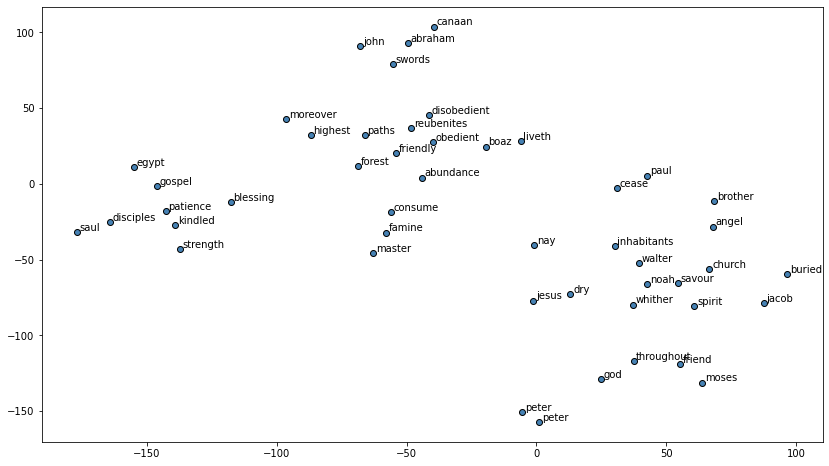

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')